In [1]:
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import re

In [2]:
fList = glob.glob('I2C_Logs_FixedDates/*log')

In [3]:
df = pd.read_csv('fullProtonInfo.csv')
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp',inplace=True)

df['RW']=-1
df['ECC']=-1
df['FC_ERROR_CNT']=np.nan
df['FC_LOCK_CNT']=np.nan
df['ALIGNER_STATUS_DONE_FLIP']=np.nan

re_fc_error_count = re.compile("^.*'fc_error_count': \(0, (\d+)\)")
re_fc_lock_count = re.compile("^.*'lock_count': \(0, (\d+)\)")
re_aligner_status_done = re.compile("^.*'status_done': \(1, 0\)")

fullReadings = []

for fName in fList:
    with open(fName) as _file:
        print(fName)
        for line in _file:
            if 'RW M' in line:
                t = pd.to_datetime(line.split(' INFO ')[0]).strftime('%Y-%m-%d %H:%M')

                RW = 1 if 'RW Mis' in line else 0
                df.loc[t,'RW']=RW

            if 'RO M' in line:
                t = pd.to_datetime(line.split(' INFO ')[0]).strftime('%Y-%m-%d %H:%M')
                fullReadings.append([t,1 if 'RO Mis' in line else 0])
                
                ECC=0
                if 'rw_ecc_err' in line:
                    if 'SINGLE' in line:
                        ECC=1
                    if 'DOUBLE' in line:
                        ECC=2
                    if 'PARITY' in line:
                        ECC=3
                
                fc_errors=0
                fc_locks=0
                if re_fc_error_count.match(line):
                    fc_errors=int(re_fc_error_count.match(line).groups()[0])
                if re_fc_lock_count.match(line):
                    fc_locks=int(re_fc_lock_count.match(line).groups()[0])
                df.loc[t,'FC_ERROR_CNT']=fc_errors
                df.loc[t,'FC_LOCK_CNT']=fc_locks
                df.loc[t,'ECC']=ECC
                
                df.loc[t,'ALIGNER_STATUS_DONE_FLIP']=1 if "status_done': (1, 0)" in line else 0
df.index = df.index.map(lambda t: pd.to_datetime(t.strftime('%Y-%m-%d %H:%M')))


I2C_Logs_FixedDates/i2cLog_Dec15_245.log
I2C_Logs_FixedDates/i2cLog_Dec15_255.log
I2C_Logs_FixedDates/i2cLog_Dec16_NoBeam_v2.log
I2C_Logs_FixedDates/i2cLog_Dec17_282_v2.log
I2C_Logs_FixedDates/i2cLog_Dec15_265_v2.log
I2C_Logs_FixedDates/i2cLog_Dec16_282_forRealThisTime_v2.log
I2C_Logs_FixedDates/i2cLog_Dec16_282_forRealThisTime_v3.log
I2C_Logs_FixedDates/i2cLog_Dec17_282_v3.log
I2C_Logs_FixedDates/i2cLog_Dec17_282.log
I2C_Logs_FixedDates/i2cLog_Dec16_NoBeam_v3.log
I2C_Logs_FixedDates/i2cLog_Dec15_275_v2.log
I2C_Logs_FixedDates/i2cLog_Dec16_282.log
I2C_Logs_FixedDates/i2cLog_Dec17_282_unmaskChAlignErr.log
I2C_Logs_FixedDates/i2cLog_Dec16_280.log
I2C_Logs_FixedDates/i2cLog_Dec17_282_v4.log
I2C_Logs_FixedDates/i2cLog_Dec16_282_forRealThisTime_v4.log
I2C_Logs_FixedDates/i2cLog_Dec16_280_debuggingFCreset.log
I2C_Logs_FixedDates/i2cLog_Dec16_275_v2_beamStarted.log
I2C_Logs_FixedDates/i2cLog_Dec15_205.log
I2C_Logs_FixedDates/i2cLog_Dec16_282_forRealThisTime.log
I2C_Logs_FixedDates/i2cLog_Dec1

In [4]:
df2=pd.DataFrame(fullReadings,columns=['Time','RO_Mismatch'])
df2.Time = pd.to_datetime(df2.Time)
df2.set_index('Time',inplace=True)
df2.index = df2.index.map(lambda t: pd.to_datetime(t.strftime('%Y-%m-%d %H:%M')))
df2.sort_index(inplace=True)

In [5]:
dfFull = df.merge(df2,left_index=True,right_index=True,how='outer')
dfFull.sort_index(inplace=True)
dfFull['Reading'] = (~dfFull.RO_Mismatch.isna()).astype(int)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


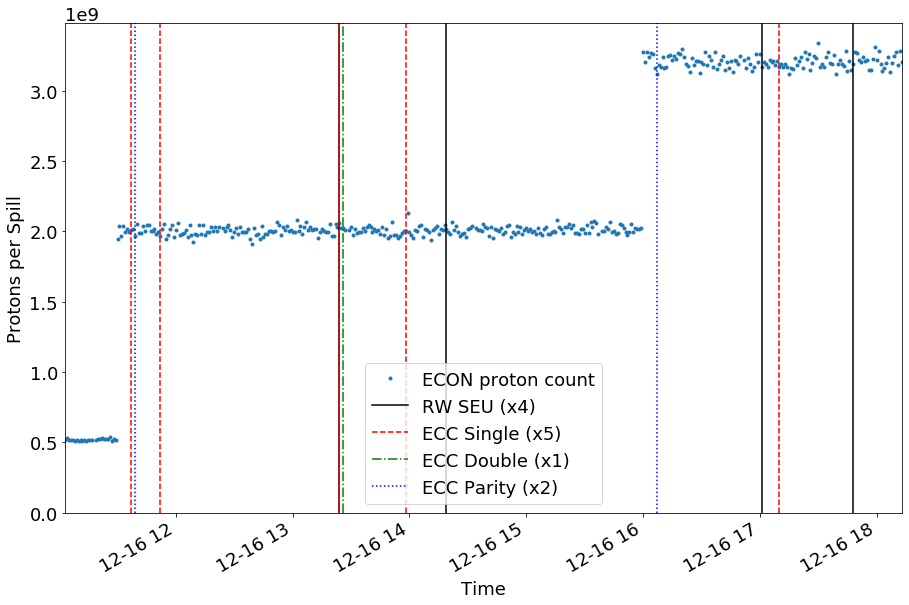

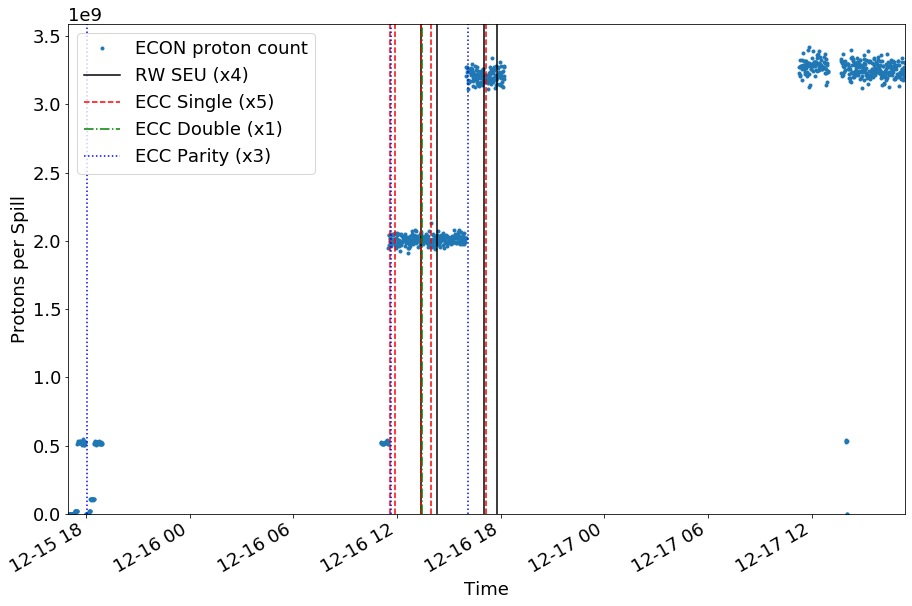

In [6]:
# t = df['2021-12-16']
t = dfFull
for t in [df['2021-12-16'],df]:
    fig,ax=plt.subplots(figsize=(15,10))
    t.plot(y='ECON proton count',ax=ax,style='.')

    t_ = t[df.RW==1]
    for i, xc in enumerate(t_.index):
        label=f'RW SEU (x{len(t_)})' if i==0 else None
        ax.axvline(x=xc, color='k', linestyle='-', label=label)

    t_ = t[df.ECC==1]
    for i, xc in enumerate(t_.index):
        label=f'ECC Single (x{len(t_)})' if i==0 else None
        ax.axvline(x=xc, color='r', linestyle='--', label=label)
    t_ = t[df.ECC==2]
    for i, xc in enumerate(t_.index):
        label=f'ECC Double (x{len(t_)})' if i==0 else None
        ax.axvline(x=xc, color='g', linestyle='-.', label=label)
    t_ = t[df.ECC==3]
    for i, xc in enumerate(t_.index):
        label=f'ECC Parity (x{len(t_)})' if i==0 else None
        ax.axvline(x=xc, color='b', linestyle=':', label=label)
    ax.set_ylim(0,None)

    ax.set_ylabel('Protons per Spill',fontsize=18)
    ax.set_xlabel('Time',fontsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.yaxis.get_offset_text().set_size(18)

    ax.legend(fontsize=18);

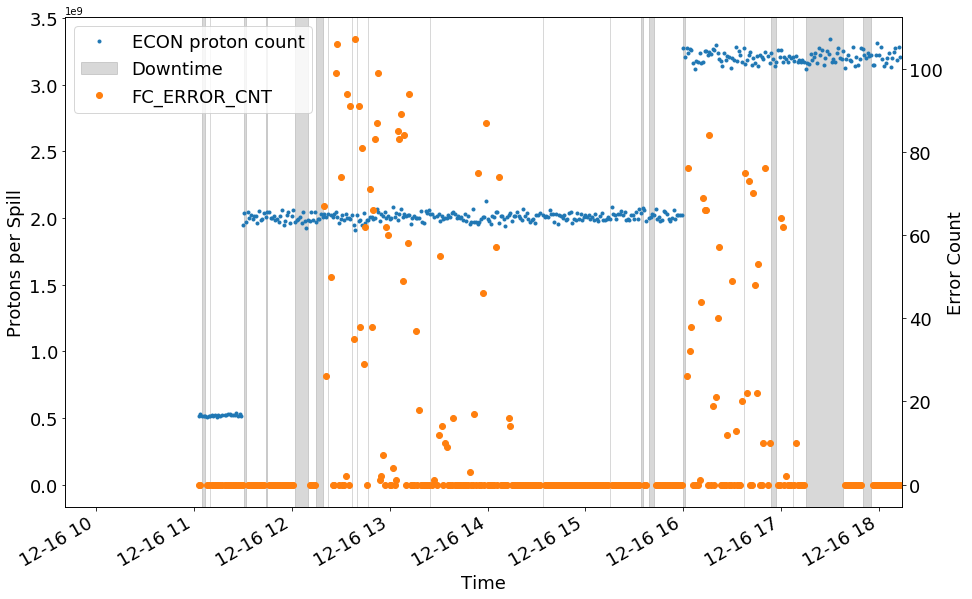

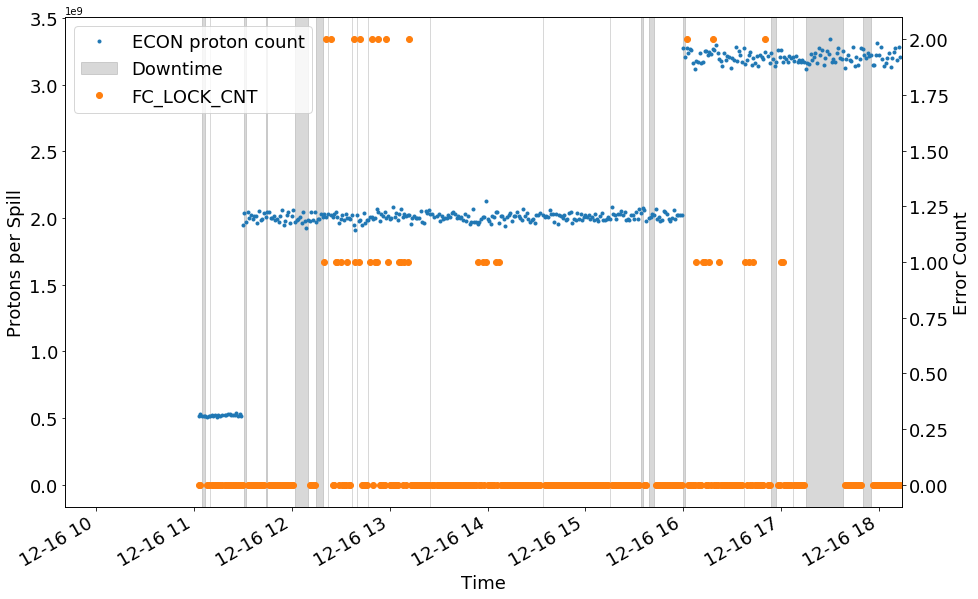

In [7]:
t = dfFull['2021-12-16']
fig,ax=plt.subplots(figsize=(15,10))
t.plot(y='ECON proton count',ax=ax,style='.')
t.plot(y='FC_ERROR_CNT',ax=ax,style='o',secondary_y=True)

ax.fill_between(t.index, 0, 1, where=t.Reading==0,
                color='gray', alpha=0.3, transform=ax.get_xaxis_transform(),label=f'Downtime')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=18)
ax.set_ylabel('Protons per Spill',fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.right_ax.set_ylabel('Error Count',fontsize=18)
ax.right_ax.tick_params(axis='y', labelsize=18)

t = dfFull['2021-12-16']
fig,ax=plt.subplots(figsize=(15,10))
t.plot(y='ECON proton count',ax=ax,style='.')
t.plot(y='FC_LOCK_CNT',ax=ax,style='o',secondary_y=True)

ax.fill_between(t.index, 0, 1, where=t.Reading==0,
                color='gray', alpha=0.3, transform=ax.get_xaxis_transform(),label=f'Downtime')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=18)
ax.set_ylabel('Protons per Spill',fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.right_ax.set_ylabel('Error Count',fontsize=18)
ax.right_ax.tick_params(axis='y', labelsize=18)


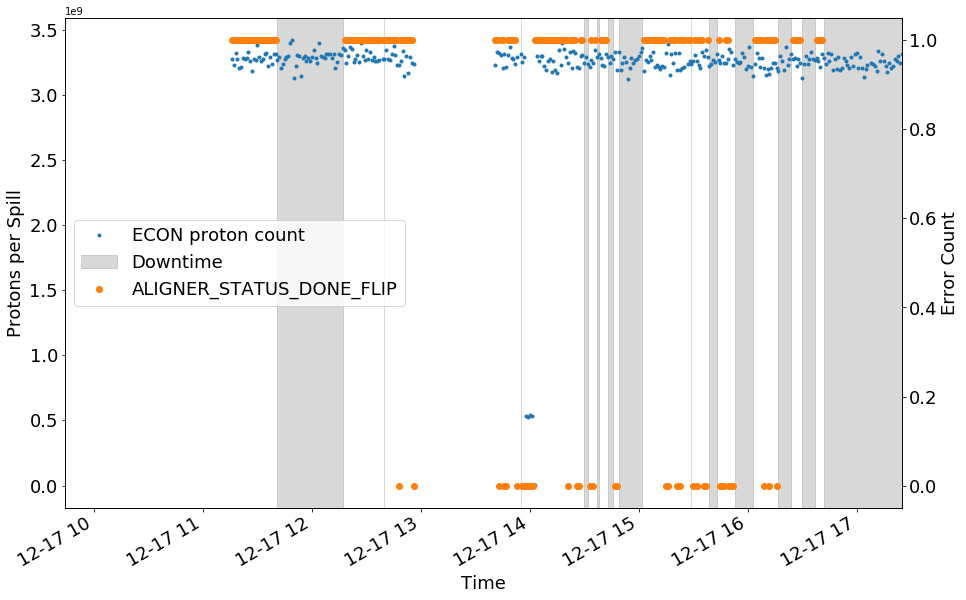

In [8]:

#t = dfFull['2021-12-17 13:30':'2021-12-17 14:30']
t = dfFull['2021-12-17']
fig,ax=plt.subplots(figsize=(15,10))
t.plot(y='ECON proton count',ax=ax,style='.')
t.plot(y='ALIGNER_STATUS_DONE_FLIP',ax=ax,style='o',secondary_y=True)

ax.fill_between(t.index, 0, 1, where=t.Reading==0,
                color='gray', alpha=0.3, transform=ax.get_xaxis_transform(),label=f'Downtime')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax.right_ax.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=18,loc='center left')
ax.set_ylabel('Protons per Spill',fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.right_ax.set_ylabel('Error Count',fontsize=18)
ax.right_ax.tick_params(axis='y', labelsize=18)


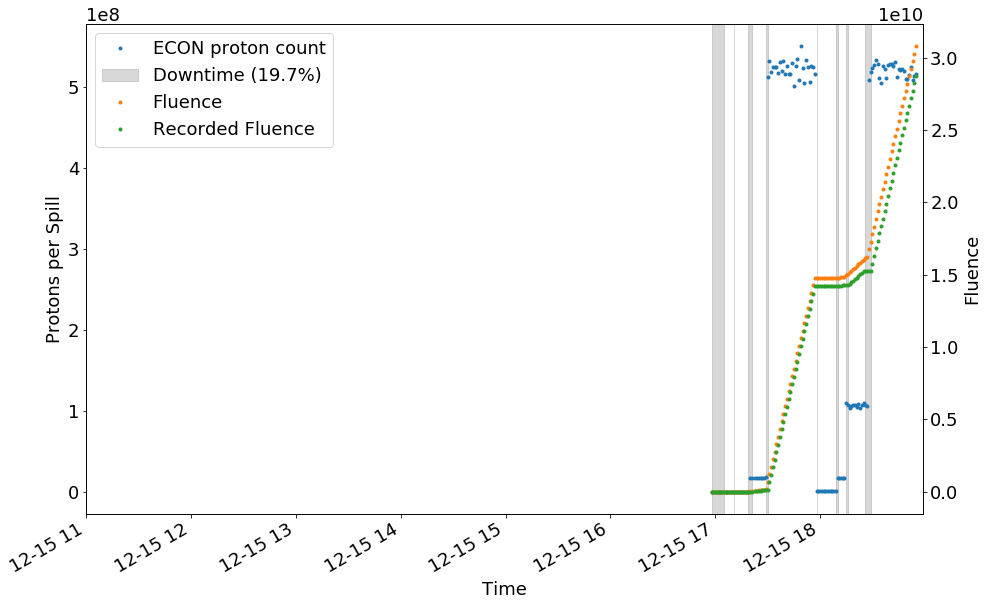

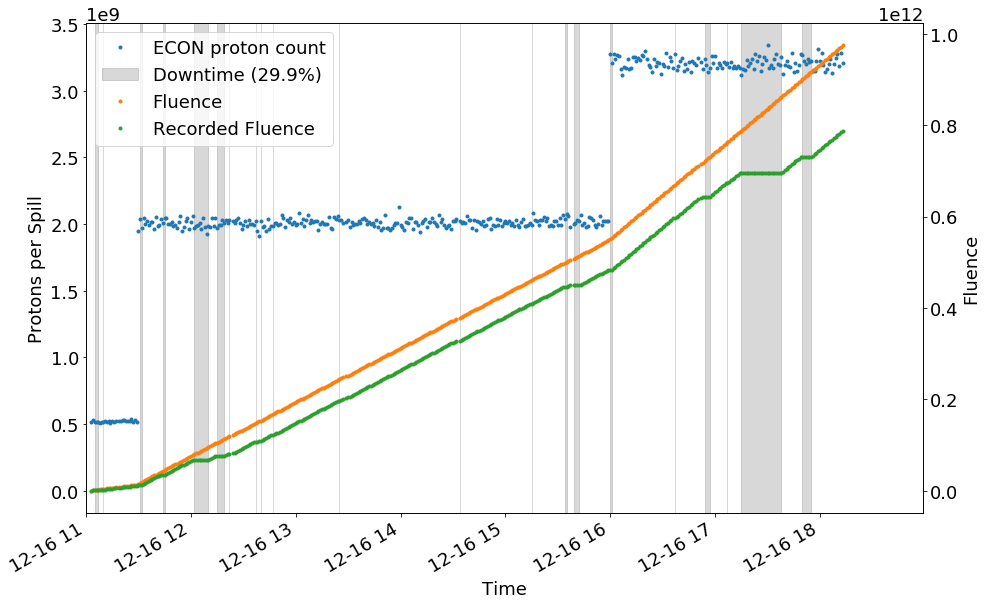

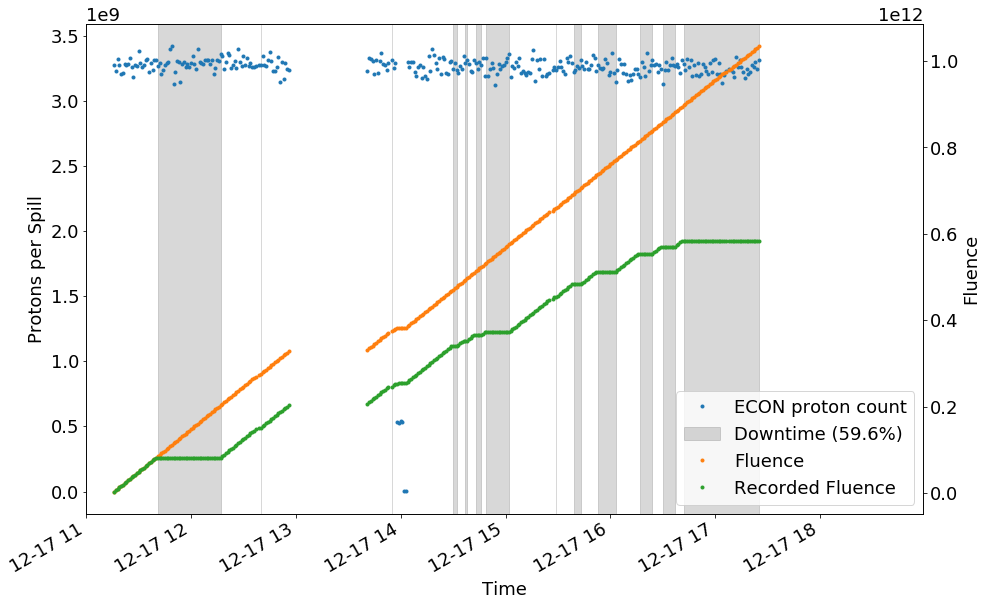

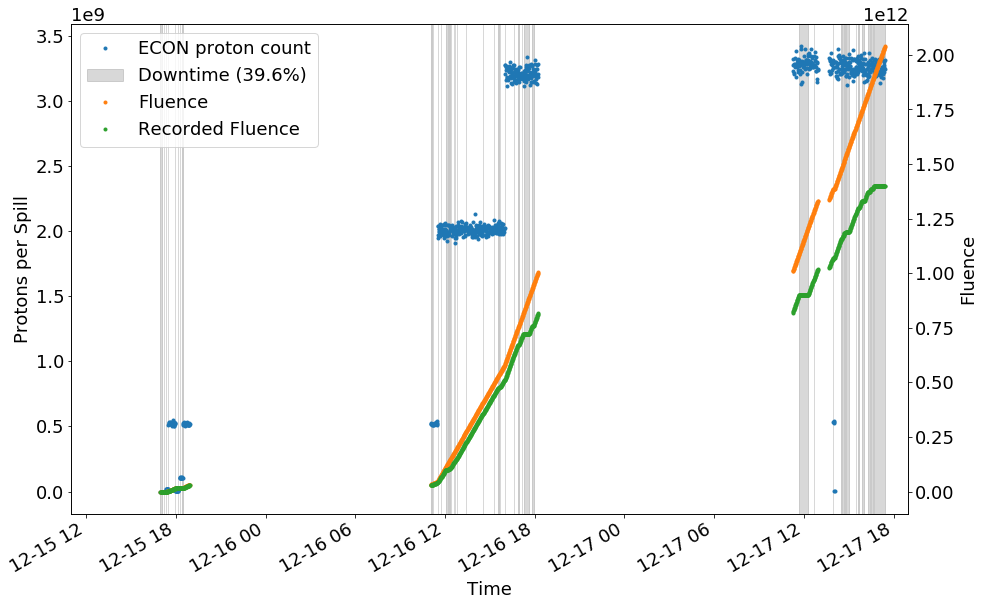

In [9]:

for time in ['2021-12-15','2021-12-16','2021-12-17','Full']:
    t=dfFull[time] if not time is 'Full' else dfFull
    fig,ax=plt.subplots(figsize=(15,10))
    t.plot(y='ECON proton count',ax=ax,style='.')
    (t['ECON proton count']).cumsum().plot(ax=ax,label='Fluence', style='.',secondary_y=True)
    (t['ECON proton count']*t.Reading).cumsum().plot(ax=ax,label='Recorded Fluence', style='.',secondary_y=True)
    downtime=(~t['proton count'].isna() & t.Reading==0).sum()/(~t['proton count'].isna()).sum()*100
    ax.fill_between(t.index, 0, 1, where=t.Reading==0,
                    color='gray', alpha=0.3, transform=ax.get_xaxis_transform(),label=f'Downtime ({round(downtime,1)}%)')

    if not time is 'Full': 
        ax.set_xlim(time+' 11:00', time+' 18:59')
    else:
        ax.set_xlim('2021-12-15 11:00', '2021-12-17 18:59')
    ax.set_ylabel('Protons per Spill',fontsize=18)
    ax.set_xlabel('Time',fontsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.yaxis.get_offset_text().set_size(18)
    ax.right_ax.set_ylabel('Fluence',fontsize=18)
    ax.right_ax.tick_params(axis='y', labelsize=18)
    ax.right_ax.yaxis.get_offset_text().set_size(18)
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax.right_ax.get_legend_handles_labels()
    loc='best'
    if time == '2021-12-17': 
        loc='lower right'
    ax.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=18,loc=loc)


In [10]:
fList = glob.glob('I2C_Logs_FixedDates/*Dec17*log')

In [11]:
re_snapshot = re.compile("^(.*) INFO\s+CH_ALIGNER_(\d+)_snapshot (.*)$")

snapshots=[]
for fName in fList:
    with open(fName) as _file:
        print(fName)
        for line in _file:
            
            if re_snapshot.match(line):
                x=re_snapshot.match(line).groups()
                if x[1]=='0':
                    t=x[0]
                snapshots.append([t,x[1],x[2]])
                

I2C_Logs_FixedDates/i2cLog_Dec17_282_v2.log
I2C_Logs_FixedDates/i2cLog_Dec17_282_v3.log
I2C_Logs_FixedDates/i2cLog_Dec17_282.log
I2C_Logs_FixedDates/i2cLog_Dec17_282_unmaskChAlignErr.log
I2C_Logs_FixedDates/i2cLog_Dec17_282_v4.log
I2C_Logs_FixedDates/i2cLog_Dec17_282_NoBeam.log


In [12]:
df_snapshot=pd.DataFrame(snapshots[:],columns=['Time','Ch','Snapshot'])
df_snapshot.Time=pd.to_datetime(df_snapshot.Time)
df_snapshot.Ch=df_snapshot.Ch.astype(int)

df_snapshot=df_snapshot.pivot(index='Time',columns='Ch',values='Snapshot')


In [13]:

#vertical vote to determine correct value
x = np.vectorize(int)(df_snapshot.values,16)
vote=np.zeros_like(x)[:,0]
bitAgreement=np.zeros_like(x)
for i in range(128):
    bit=(((x>>i)&1).sum(axis=1)>6).astype(int)
    vote += (((x>>i)&1).sum(axis=1)>6).astype(object)<<i
    bitAgreement += (((x>>i)&1).T==bit).astype(int).T
vote = np.vectorize(hex)(vote)

df_bitAgreement=pd.DataFrame(bitAgreement,index=df_snapshot.index,columns=[f'eRx_{i}' for i in range(12)])

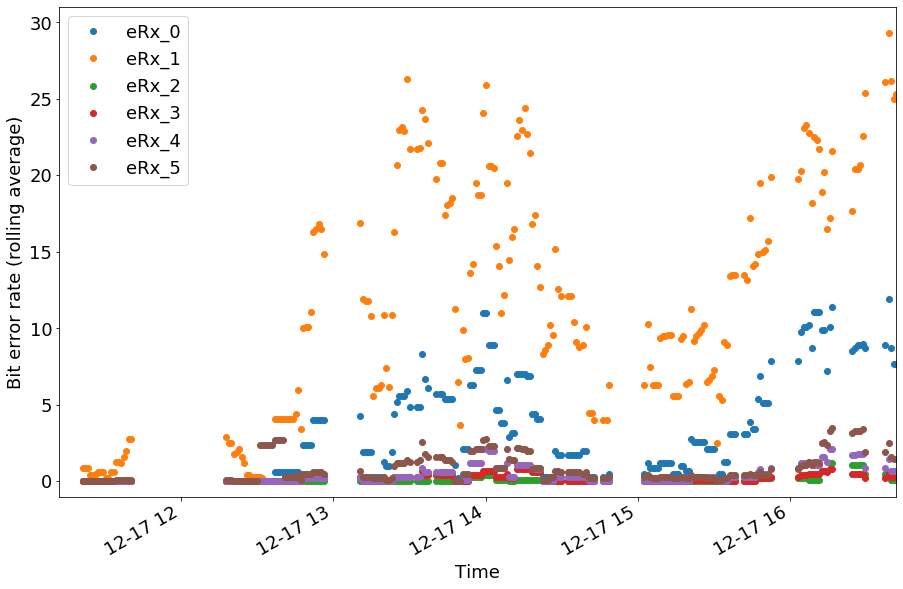

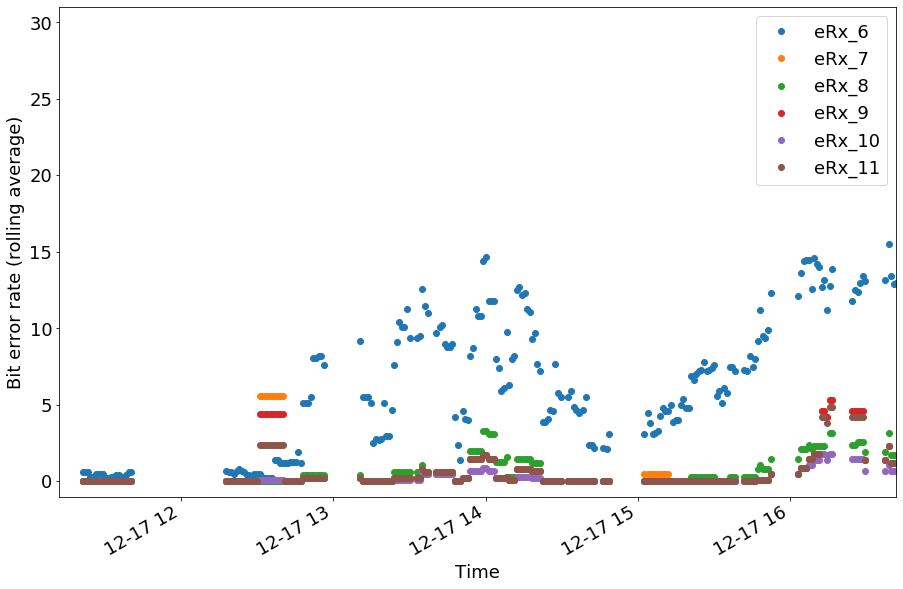

In [14]:
#get average of 10 samples
x = df_bitAgreement.rolling(10).mean()

fig,ax=plt.subplots(figsize=(15,10))
(128-x).iloc[:,:6].plot(ax=ax,style='o')
ax.set_ylabel('Bit error rate (rolling average)',fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylim(-1,31)
ax.legend(fontsize=18)

fig,ax=plt.subplots(figsize=(15,10))
(128-x).iloc[:,6:].plot(ax=ax,style='o')
ax.set_ylabel('Bit error rate (rolling average)',fontsize=18)
ax.set_xlabel('Time',fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylim(-1,31)
ax.legend(fontsize=18)
